# Some Resources and References Used:

* https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da
* https://monkeylearn.com/blog/named-entity-recognition/
* https://www.nltk.org/book/ch07.html
* https://nlpforhackers.io/named-entity-extraction/


## Approach:

1. Conduct Exploratory Data Analysis to get better understanding of data
2. Perform any necessary Data Cleaning
3. Train Different Classification Models
    * using similar approach to my https://github.com/jqypang915/spamorham project
4. Apply Multiple Models to Testing Dataset
5. Review + Conclusion + Next Steps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.metrics import classification_report
from sklearn import metrics



pd.options.mode.chained_assignment = None


In [2]:
df = pd.read_csv("train.txt", sep="\t")
df

@paulwalk  O
0            It  O
1            's  O
2           the  O
3          view  O
4          from  O
...         ... ..
57887        39  O
57888  GMT+0000  O
57889         (  O
57890       UTC  O
57891         )  O

[57892 rows x 2 columns]

# Exploratory Data Analysis

In [3]:
df.columns = ['word', 'label']

In [4]:
df['label'].unique()

array(['O', 'B-location', 'I-location', nan, 'B-group', 'B-corporation',
       'B-person', 'B-creative-work', 'B-product', 'I-person',
       'I-creative-work', 'I-corporation', 'I-group', 'I-product'],
      dtype=object)

In [5]:
df[df['label'].isna()]


word label
26     NaN   NaN
42     NaN   NaN
55     NaN   NaN
65     NaN   NaN
78     NaN   NaN
...    ...   ...
43400  NaN   NaN
43428  NaN   NaN
43456  NaN   NaN
43477  NaN   NaN
43490  NaN   NaN

[2162 rows x 2 columns]

In [6]:
df = df.dropna()
df

word label
0            It     O
1            's     O
2           the     O
3          view     O
4          from     O
...         ...   ...
57887        39     O
57888  GMT+0000     O
57889         (     O
57890       UTC     O
57891         )     O

[55724 rows x 2 columns]

In [7]:
df['label'].unique()

array(['O', 'B-location', 'I-location', 'B-group', 'B-corporation',
       'B-person', 'B-creative-work', 'B-product', 'I-person',
       'I-creative-work', 'I-corporation', 'I-group', 'I-product'],
      dtype=object)

In [8]:
len(df['label'].unique())

13

In [9]:
df.groupby('label').count().sort_values('word', ascending = False)

word
label                 
O                52996
B-person           566
B-location         494
I-person           288
B-group            230
I-location         226
B-corporation      196
I-product          163
I-creative-work    150
I-group            132
B-product          130
B-creative-work    110
I-corporation       43

In [10]:
df.word.unique()

array(['It', "'s", 'the', ..., '12:46', 'GMT+0000', 'UTC'], dtype=object)

In [11]:
# Gettting Character Count
df['char_length'] = df['word'].apply(len)
df

word label  char_length
0            It     O            2
1            's     O            2
2           the     O            3
3          view     O            4
4          from     O            4
...         ...   ...          ...
57887        39     O            2
57888  GMT+0000     O            8
57889         (     O            1
57890       UTC     O            3
57891         )     O            1

[55724 rows x 3 columns]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. P

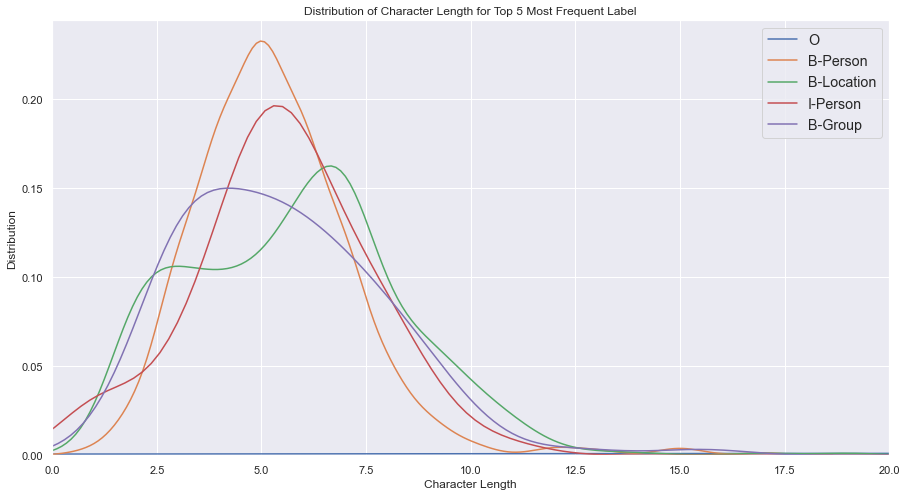

In [12]:
# Visualizing char_length for top 5 most frequent labels
sns.set(style="darkgrid")

plt.figure(figsize=(15, 8))
O_length = df[df['label'] == 'O'][['char_length']]
B_person_length = df[df['label'] == 'B-person'][['char_length']]
B_location_length = df[df['label'] == 'B-location'][['char_length']]
I_Person_length = df[df['label'] == 'I-person'][['char_length']]
B_Group_length = df[df['label'] == 'B-group'][['char_length']]
ax = sns.distplot(O_length, hist = False, label = 'O')
ax = sns.distplot(B_person_length, hist = False, label = 'B-Person')
ax = sns.distplot(B_location_length, hist = False, label = 'B-Location')
ax = sns.distplot(I_Person_length, hist = False, label = 'I-Person')
ax = sns.distplot(B_Group_length, hist = False, label = 'B-Group')
plt.xlim(0, 20)
plt.title('Distribution of Character Length for Top 5 Most Frequent Label')
sns.set(font_scale=1.3)
ax.set_ylabel('Distribution')
ax.set_xlabel('Character Length')
plt.legend()
plt.show()

In [13]:
# Adding Capitalization Column
df['capitalize'] = df['word'].apply(lambda s: any(x.isupper() for x in s))
df

word label  char_length  capitalize
0            It     O            2        True
1            's     O            2       False
2           the     O            3       False
3          view     O            4       False
4          from     O            4       False
...         ...   ...          ...         ...
57887        39     O            2       False
57888  GMT+0000     O            8        True
57889         (     O            1       False
57890       UTC     O            3        True
57891         )     O            1       False

[55724 rows x 4 columns]

In [14]:
# Adding A Column for whether word contains a number
df['numeric'] = df['word'].apply(lambda s: any(x.isdigit() for x in s))
df

word label  char_length  capitalize  numeric
0            It     O            2        True    False
1            's     O            2       False    False
2           the     O            3       False    False
3          view     O            4       False    False
4          from     O            4       False    False
...         ...   ...          ...         ...      ...
57887        39     O            2       False     True
57888  GMT+0000     O            8        True     True
57889         (     O            1       False    False
57890       UTC     O            3        True    False
57891         )     O            1       False    False

[55724 rows x 5 columns]

In [15]:
df['punctuation'] = df['word'].apply(lambda s: any(x in string.punctuation for x in s))
df

word label  char_length  capitalize  numeric  punctuation
0            It     O            2        True    False        False
1            's     O            2       False    False         True
2           the     O            3       False    False        False
3          view     O            4       False    False        False
4          from     O            4       False    False        False
...         ...   ...          ...         ...      ...          ...
57887        39     O            2       False     True        False
57888  GMT+0000     O            8        True     True         True
57889         (     O            1       False    False         True
57890       UTC     O            3        True    False        False
57891         )     O            1       False    False         True

[55724 rows x 6 columns]

In [16]:
# Getting Parts of Speech
def word_pos(word):
    val = nltk.pos_tag(word) 
    return val[0][1]

word_pos(["car"])

df['pos'] = df['word'].apply(lambda s: word_pos([s]))
df

word label  char_length  capitalize  numeric  punctuation  pos
0            It     O            2        True    False        False  PRP
1            's     O            2       False    False         True  POS
2           the     O            3       False    False        False   DT
3          view     O            4       False    False        False   NN
4          from     O            4       False    False        False   IN
...         ...   ...          ...         ...      ...          ...  ...
57887        39     O            2       False     True        False   CD
57888  GMT+0000     O            8        True     True         True   NN
57889         (     O            1       False    False         True    (
57890       UTC     O            3        True    False        False   NN
57891         )     O            1       False    False         True    )

[55724 rows x 7 columns]

In [17]:
# Using Named Entity Recognition from NLTK to get entity value for each word based off the 2 closest words

words = list(df['word'])

ne = []

for i in np.arange(len(words)):
    token = []
    
    if i == 0:
        token.append(words[i])
        token.append(words[i+1])
        token.append(words[i+2])
        ne.append(nltk.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(token)))[0][2])
    elif i == len(words):
        token.append(words[i-1])
        token.append(words[i])
        token.append(words[i+1])
        ne.append(nltk.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(token)))[1][2])

    else:
        token.append(words[i-2])
        token.append(words[i-1])
        token.append(words[i])
        ne.append(nltk.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(token)))[2][2])
        

ne

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PERSON',
 'I-PERSON',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GPE',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-PERSON',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-PERSON',
 'O',
 'O',
 'O',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PERSON',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',

In [21]:
df['ne'] = ne
df

word label  char_length  capitalize  numeric  punctuation  pos  \
0            It     O            2           1        0            0  PRP   
1            's     O            2           0        0            1  POS   
2           the     O            3           0        0            0   DT   
3          view     O            4           0        0            0   NN   
4          from     O            4           0        0            0   IN   
...         ...   ...          ...         ...      ...          ...  ...   
57887        39     O            2           0        1            0   CD   
57888  GMT+0000     O            8           1        1            1   NN   
57889         (     O            1           0        0            1    (   
57890       UTC     O            3           1        0            0   NN   
57891         )     O            1           0        0            1    )   

                   ne  
0                   O  
1                   O  
2                   O  
3                   O  
4                   O  
...               ...  
57887               O  
57888               O  
57889               O  
57890  B-ORGANIZATION  
57891               O  

[55724 rows x 8 columns]

In [22]:
# Converting POS and NE columns into numeric values for model training

df["numeric"] = df["numeric"].astype(int)
df["capitalize"] = df["capitalize"].astype(int)
df["punctuation"] = df["punctuation"].astype(int)
df

word label  char_length  capitalize  numeric  punctuation  pos  \
0            It     O            2           1        0            0  PRP   
1            's     O            2           0        0            1  POS   
2           the     O            3           0        0            0   DT   
3          view     O            4           0        0            0   NN   
4          from     O            4           0        0            0   IN   
...         ...   ...          ...         ...      ...          ...  ...   
57887        39     O            2           0        1            0   CD   
57888  GMT+0000     O            8           1        1            1   NN   
57889         (     O            1           0        0            1    (   
57890       UTC     O            3           1        0            0   NN   
57891         )     O            1           0        0            1    )   

                   ne  
0                   O  
1                   O  
2                   O  
3                   O  
4                   O  
...               ...  
57887               O  
57888               O  
57889               O  
57890  B-ORGANIZATION  
57891               O  

[55724 rows x 8 columns]

In [23]:
# Reorganizing pos and ne tables 

# Saving Values for Testing
train_pos = df['pos'].unique()
train_ne = df['ne'].unique()

for x in train_pos:
    df[x] = df['pos'].apply(lambda s: s == x).astype(int)

for x in train_ne:
    df[x] = df['ne'].apply(lambda s: s == x).astype(int)

    
df

word label  char_length  capitalize  numeric  punctuation  pos  \
0            It     O            2           1        0            0  PRP   
1            's     O            2           0        0            1  POS   
2           the     O            3           0        0            0   DT   
3          view     O            4           0        0            0   NN   
4          from     O            4           0        0            0   IN   
...         ...   ...          ...         ...      ...          ...  ...   
57887        39     O            2           0        1            0   CD   
57888  GMT+0000     O            8           1        1            1   NN   
57889         (     O            1           0        0            1    (   
57890       UTC     O            3           1        0            0   NN   
57891         )     O            1           0        0            1    )   

                   ne  PRP  POS  ...  I-PERSON  B-GPE  I-ORGANIZATION  \
0                   O    1    0  ...         0      0               0   
1                   O    0    1  ...         0      0               0   
2                   O    0    0  ...         0      0               0   
3                   O    0    0  ...         0      0               0   
4                   O    0    0  ...         0      0               0   
...               ...  ...  ...  ...       ...    ...             ...   
57887               O    0    0  ...         0      0               0   
57888               O    0    0  ...         0      0               0   
57889               O    0    0  ...         0      0               0   
57890  B-ORGANIZATION    0    0  ...         0      0               0   
57891               O    0    0  ...         0      0               0   

       B-ORGANIZATION  I-GPE  I-FACILITY  B-GSP  B-FACILITY  B-LOCATION  \
0                   0      0           0      0           0           0   
1                   0      0           0      0           0           0   
2                   0      0           0      0           0           0   
3                   0      0           0      0           0           0   
4                   0      0           0      0           0           0   
...               ...    ...         ...    ...         ...         ...   
57887               0      0           0      0           0           0   
57888               0      0           0      0           0           0   
57889               0      0           0      0           0           0   
57890               1      0           0      0           0           0   
57891               0      0           0      0           0           0   

       I-LOCATION  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
57887           0  
57888           0  
57889           0  
57890           0  
57891           0  

[55724 rows x 61 columns]

In [24]:
df = df.drop(columns = ['pos','ne'])
df

word label  char_length  capitalize  numeric  punctuation  PRP  \
0            It     O            2           1        0            0    1   
1            's     O            2           0        0            1    0   
2           the     O            3           0        0            0    0   
3          view     O            4           0        0            0    0   
4          from     O            4           0        0            0    0   
...         ...   ...          ...         ...      ...          ...  ...   
57887        39     O            2           0        1            0    0   
57888  GMT+0000     O            8           1        1            1    0   
57889         (     O            1           0        0            1    0   
57890       UTC     O            3           1        0            0    0   
57891         )     O            1           0        0            1    0   

       POS  DT  NN  ...  I-PERSON  B-GPE  I-ORGANIZATION  B-ORGANIZATION  \
0        0   0   0  ...         0      0               0               0   
1        1   0   0  ...         0      0               0               0   
2        0   1   0  ...         0      0               0               0   
3        0   0   1  ...         0      0               0               0   
4        0   0   0  ...         0      0               0               0   
...    ...  ..  ..  ...       ...    ...             ...             ...   
57887    0   0   0  ...         0      0               0               0   
57888    0   0   1  ...         0      0               0               0   
57889    0   0   0  ...         0      0               0               0   
57890    0   0   1  ...         0      0               0               1   
57891    0   0   0  ...         0      0               0               0   

       I-GPE  I-FACILITY  B-GSP  B-FACILITY  B-LOCATION  I-LOCATION  
0          0           0      0           0           0           0  
1          0           0      0           0           0           0  
2          0           0      0           0           0           0  
3          0           0      0           0           0           0  
4          0           0      0           0           0           0  
...      ...         ...    ...         ...         ...         ...  
57887      0           0      0           0           0           0  
57888      0           0      0           0           0           0  
57889      0           0      0           0           0           0  
57890      0           0      0           0           0           0  
57891      0           0      0           0           0           0  

[55724 rows x 59 columns]

# Applying Dataformatting Changes to Testing Data

In [25]:
test = pd.read_csv('test.txt', sep='\t',engine='python', encoding='utf-8', error_bad_lines=False) 
test.columns = ['word']
test = test.dropna()
test['char_length'] = test['word'].apply(len)
test['capitalize'] = test['word'].apply(lambda s: any(x.isupper() for x in s)).astype(int)
test['numeric'] = test['word'].apply(lambda s: any(x.isdigit() for x in s)).astype(int)
test['punctuation'] = test['word'].apply(lambda s: any(x in string.punctuation for x in s)).astype(int)
test['pos'] = test['word'].apply(lambda s: word_pos([s]))


words = list(test['word'])

ne = []

for i in np.arange(len(words)):
    token = []
    
    if i == 0:
        token.append(words[i])
        token.append(words[i+1])
        token.append(words[i+2])
        ne.append(nltk.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(token)))[0][2])
    elif i == len(words):
        token.append(words[i-1])
        token.append(words[i])
        token.append(words[i+1])
        ne.append(nltk.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(token)))[1][2])

    else:
        token.append(words[i-2])
        token.append(words[i-1])
        token.append(words[i])
        ne.append(nltk.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(token)))[2][2])

test['ne'] = ne

for x in train_pos:
    test[x] = test['pos'].apply(lambda s: s == x).astype(int)

for x in train_ne:
    test[x] = test['ne'].apply(lambda s: s == x).astype(int)
    
test_words = test[['word']]
test = test.drop(columns = ['pos','ne', 'word'])


test

Skipping line 8549: unexpected end of data


char_length  capitalize  numeric  punctuation  PRP  POS  DT  NN  IN  \
0               2           0        0            0    0    0   0   1   0   
1               1           0        0            1    0    0   0   0   0   
2               1           0        0            1    0    0   0   1   0   
3               3           1        0            0    0    0   1   0   0   
4               7           0        0            0    0    0   0   1   0   
...           ...         ...      ...          ...  ...  ...  ..  ..  ..   
8138            4           0        0            0    0    0   0   0   1   
8139         2187           1        1            1    0    0   0   1   0   
8140            3           0        0            0    0    0   0   0   0   
8141            4           0        0            0    0    0   0   1   0   
8142            1           0        0            1    0    0   0   0   0   

      WRB  ...  I-PERSON  B-GPE  I-ORGANIZATION  B-ORGANIZATION  I-GPE  \
0       0  ...         0      0               0               0      0   
1       0  ...         0      0               0               0      0   
2       0  ...         0      0               0               0      0   
3       0  ...         0      0               0               0      0   
4       0  ...         0      0               0               0      0   
...   ...  ...       ...    ...             ...             ...    ...   
8138    0  ...         0      0               0               0      0   
8139    0  ...         0      0               0               0      0   
8140    0  ...         0      0               0               0      0   
8141    0  ...         0      0               0               0      0   
8142    0  ...         0      0               0               0      0   

      I-FACILITY  B-GSP  B-FACILITY  B-LOCATION  I-LOCATION  
0              0      0           0           0           0  
1              0      0           0           0           0  
2              0      0           0           0           0  
3              0      0           0           0           0  
4              0      0           0           0           0  
...          ...    ...         ...         ...         ...  
8138           0      0           0           0           0  
8139           0      0           0           0           0  
8140           0      0           0           0           0  
8141           0      0           0           0           0  
8142           0      0           0           0           0  

[8142 rows x 57 columns]

# Training Machine Learning Models

Since classification problem, I will be testing/using 3 models: Logisitic Regression, Random Forest, Naive Bayes. I chose Logisitic Regression and Random Forest since both are widely used classifiers. Naive Bayes was selected for it is usually well suited for word and sentence classification tasks.

In [26]:
# Splitting the Training Data into
from sklearn.model_selection import train_test_split

x = df.drop(columns = ['label'])
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=40)

x_train = x_train.drop(columns = 'word')

x_test = x_test.drop(columns = 'word')
x_test

char_length  capitalize  numeric  punctuation  PRP  POS  DT  NN  IN  \
34654           16           1        1            1    0    0   0   1   0   
52168            7           0        0            0    0    0   0   0   0   
34872            9           0        0            1    0    0   0   0   0   
597              3           0        0            0    0    0   0   0   1   
54427            3           1        0            0    0    0   0   1   0   
...            ...         ...      ...          ...  ...  ...  ..  ..  ..   
11326           10           0        0            0    0    0   0   1   0   
51588            2           1        0            0    0    0   0   1   0   
11276            6           0        0            0    0    0   0   0   1   
30015            6           0        0            0    0    0   0   1   0   
45949            6           1        0            0    0    0   0   0   0   

       WRB  ...  I-PERSON  B-GPE  I-ORGANIZATION  B-ORGANIZATION  I-GPE  \
34654    0  ...         0      0               0               0      0   
52168    0  ...         0      0               0               0      0   
34872    0  ...         0      0               0               0      0   
597      0  ...         0      0               0               0      0   
54427    0  ...         0      0               0               0      0   
...    ...  ...       ...    ...             ...             ...    ...   
11326    0  ...         0      0               0               0      0   
51588    0  ...         0      0               0               0      0   
11276    0  ...         0      0               0               0      0   
30015    0  ...         0      0               0               0      0   
45949    0  ...         0      0               0               0      0   

       I-FACILITY  B-GSP  B-FACILITY  B-LOCATION  I-LOCATION  
34654           0      0           0           0           0  
52168           0      0           0           0           0  
34872           0      0           0           0           0  
597             0      0           0           0           0  
54427           0      0           0           0           0  
...           ...    ...         ...         ...         ...  
11326           0      0           0           0           0  
51588           0      0           0           0           0  
11276           0      0           0           0           0  
30015           0      0           0           0           0  
45949           0      0           0           0           0  

[18389 rows x 57 columns]

In [27]:
# This training takes a very long time since a lot of iterations
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter = 5000)
lg_bal = LogisticRegression(max_iter = 5000)

lg.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_bal = RandomForestClassifier()

rf.fit(x_train, y_train)

RandomForestClassifier()

In [29]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb_bal = MultinomialNB()

nb.fit(x_train, y_train)

MultinomialNB()

In [30]:
lg_pred = lg.predict(x_test)
metrics.accuracy_score(y_test, lg_pred)

0.9538854750122355

In [31]:
rf_pred = rf.predict(x_test)
metrics.accuracy_score(y_test, rf_pred)

0.9536679536679536

In [32]:
nb_pred = nb.predict(x_test)
metrics.accuracy_score(y_test, nb_pred)

0.9474685953559193

## Quick Analysis:

Overall the models are much more accurate than expected. I inclined to say that the ne column and pos columns probabily contributed the most to this high accuracy. Granted, since I am not doing extensive training iterations, my model could very well be overfitting. For all I know my model could be returning all 'O', and since we have so many 'O' categories over any other category, my percentage correct would be high as well.

As for now, I will be picking the best model, the Logistic Regression Model, to run the testing data through. 

In [33]:
test_labels = lg.predict(test)
test_labels

array(['O', 'O', 'O', ..., 'O', 'O', 'O'], dtype=object)

In [34]:
# Testing CSV File
test_words['label'] = test_labels
test_words.to_csv('test_output.csv', index = False)
test_words

word label
0                                                    gt     O
1                                                     ;     O
2                                                     *     O
3                                                   The     O
4                                               soldier     O
...                                                 ...   ...
8138                                               like     O
8139  \ni\n'\nve\nstalked\nur\nInstagr\n…\n\ngrave\n...     O
8140                                                its     O
8141                                               fine     O
8142                                                  .     O

[8142 rows x 2 columns]

# Future Improvements:

If I had more time, here would be the following improvements that I would implement:
1. __Adding more Named Entity Recognizers__: Through research of named entities, I can across many other entity recognizers such as Spacy and monkeylearn. Unlike what I am used to, there wasn't much data to go off of for a singluar word. If I used other Named Entity Recognizers, perhaps could have made a better model.

2. __Named Entity Recognition Implementation__: While I did implement NLTK's ne_chunk, I could have done it much better. For one, I only applied ne_chunk to the 2 nearest words. If I could instead apply ne_chunk to the entire sentence, and then retrieved the category for each word respectively, that would return much better data. The main thing that stopped me from this implmentation is not knowing how to separate the sentences properly.

3. __Cross Validation__: Overall, I didn't really fine-tune my classification model, I simply used the defaults and picked the best model out of the three. It would have been much wiser to use cross validation during the training in order to get better model and to make sure that I don't overfit. 

4. __Balance Correction__: When looking at the categories/labels given in the original dataset, there were significantly more O categories than any other category. As a result, our model could have been unfairly biased towards 'O' category. Implementation of a balance correction method could help us make a better model. Currently I am mainly acquainted with SMOTE, which I don't think would be the best balance correction method for this task for we are only given a singular word.

5. __More Exploration of ML Models__: Due to time restraints preventing me research other classifier models, I only tested and used the ones that I was familar with